# Show possible metrics to quantitatively judge the results

In [1]:
from tools.spectral_tools import *
from tools.metrics import *
from tools.normalize_np import normalize_np
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
from tools.hsi_to_rgb import hsi_to_rgb
import torch
from dataset import open_mat
import cv2

from loss import SpectralLoss, StructuralLoss
import math

import os
import h5py

In [5]:
basepath = r"Datasets/aviva_earring_aligned_r6_all_wl.mat"
matfile_in = io.loadmat(basepath)
wl_cal = np.squeeze(matfile_in["Wavelengths"])
# wl_cal = wl_cal[::100]
lr = matfile_in["I_MS_LR"]
lr_rgb = hsi_to_rgb(lr, wl_cal)

pan = matfile_in["I_PAN"]

matfile_out = io.loadmat(
    r"Outputs/R-PNN/20250710_123218/aviva_earring_aligned_r6_all_wl_R-PNN.mat"
    # r"Outputs/R-PNN/20250620_192347/aviva_face_aligned_r6_rwl_R-PNN.mat"
)
sr = np.squeeze(matfile_out["I_MS"].astype(np.float32))
sr = np.transpose(sr, (1, 2, 0))
sr_rgb = hsi_to_rgb(sr, wl_cal)

def show_image(img, dpi=100):
    height, width = img.shape[:2]
    figsize = (width / dpi, height / dpi)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    #fig, ax = plt.subplots()
    ax.imshow(img)
    # ax.axis('off')
    plt.show()

show_image(lr_rgb)
show_image(sr_rgb)
show_image(pan)


FileNotFoundError: [Errno 2] No such file or directory: 'Outputs/R-PNN/20250710_123218/aviva_earring_aligned_r6_all_wl_R-PNN.mat'

In [ ]:
# downgrade the pansharpened image
mtf_kernel_size = 15 # must be greater than 2*ratio and odd
ratio = 6
sensor = "PRISMA" # TODO cancel the sensor arg for our version of the gen_mtf function
# mtf = gen_mtf(ratio, sensor, kernel_size=mtf_kernel_size, nbands=1)
device = torch.device("cpu")

criterion_spec = SpectralLoss(
    gen_mtf(ratio, sensor, kernel_size=mtf_kernel_size, nbands=1),
    ratio,
    device,
).to(device)

pan_ten, ms_lr_ten, ms_ten, _, wl_ten = open_mat(basepath) # open as tensors
sr_ten = torch.from_numpy(np.moveaxis(sr, -1, 0)[None, :, :, :])

# I use the loss just for the degradation part
degraded_sr = np.zeros_like(lr).astype(np.float32)
degraded_sr = torch.from_numpy(np.moveaxis(degraded_sr, -1, 0)[None, :, :, :])
for band in range(degraded_sr.shape[1]):
    _ , degraded_output = criterion_spec(sr_ten[:,band:band+1,:,:], ms_lr_ten[:,band:band+1, :,:])
    #degraded_sr.append(degraded_output)
    degraded_sr[:,band, :,:] = degraded_output

loss_spec_l2 = (degraded_sr - ms_lr_ten)**2
loss_spec_l2 = torch.sum(loss_spec_l2, dim=1, keepdim = True)
loss_spec_l1 = torch.abs(degraded_sr - ms_lr_ten)
loss_spec_l1 = torch.sum(loss_spec_l1, dim=1, keepdim = True)


height = ms_lr_ten.shape[2]
width = ms_lr_ten.shape[3]
sam_map = torch.zeros(height, width) # To store the SAM value for each pixel

for r in range(height):
    for c in range(width):
        # Extract spectral vector for pixel (r, c) from tensor_A
        # Shape will be [bands] after squeezing the batch and spatial dimensions
        spectral_vector_A = ms_lr_ten[0, :, r, c].squeeze() # Remove batch dim and spatial dims of size 1

        # Extract spectral vector for pixel (r, c) from tensor_B
        spectral_vector_B = degraded_sr[0, :, r, c].squeeze()

        # Calculate dot product
        dot_product = torch.dot(spectral_vector_A, spectral_vector_B)

        # Calculate magnitudes (L2 norms)
        norm_A = torch.linalg.norm(spectral_vector_A)
        norm_B = torch.linalg.norm(spectral_vector_B)

        # Avoid division by zero for black pixels (zero vectors)
        if norm_A == 0.0 or norm_B == 0.0:
            angle = torch.tensor(0.0) # Or NaN, depending on desired behavior for black pixels
        else:
            # Calculate cosine of the angle
            cosine_angle = dot_product / (norm_A * norm_B)
            # Clamp to prevent numerical issues (arccos domain is [-1, 1])
            cosine_angle = torch.clamp(cosine_angle, -1.0, 1.0)
            # Calculate the angle in radians
            angle = torch.acos(cosine_angle)

        sam_map[r, c] = angle

degraded_sr = np.squeeze(degraded_sr.numpy()).transpose(1,2,0)

loss_spec_l1 = np.squeeze(loss_spec_l1.numpy())
# loss_spec_l2 = np.squeeze(loss_spec_l2.numpy())
sam_map = np.squeeze(sam_map.numpy())

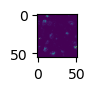

2920.0862


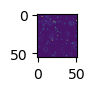

59.759575


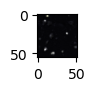

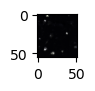

In [ ]:
show_image(loss_spec_l1)
print(np.sum(loss_spec_l1,(0,1)))
# show_image(loss_spec_l2)
# print(np.sum(loss_spec_l2,(0,1)))
show_image(sam_map)
print(np.degrees(sam_map.max()))
show_image(hsi_to_rgb(degraded_sr, wl_cal))
show_image(lr_rgb)

In [ ]:
# spatial consistency index

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [ ]:
def spatial_consistency_ds(pan, hs_pan):
    """
    Compute the spatial consistency index D_s = 1 - R^2.

    Parameters:
      pan : ndarray, shape (H, W)
        High-resolution panchromatic image.
      hs_pan : ndarray, shape (H, W, B)
        Pansharpened hyperspectral (or multispectral) bands at PAN resolution.

    Returns:
      D_s : float
        Spatial distortion index.
      R2 : float
        Coefficient of determination.
    """

    H, W = pan.shape
    B = hs_pan.shape[2]

    # Flatten into (N_samples, B) and (N_samples,)
    X = hs_pan.reshape(-1, B)
    y = pan.reshape(-1)

    # Fit linear regression with intercept
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)

    # Predict and compute R^2
    y_pred = model.predict(X)
    R2 = r2_score(y, y_pred)

    Ds = 1.0 - R2
    return Ds, R2

In [ ]:
Ds,R2 = spatial_consistency_ds(pan, sr)
print(f"{Ds}, \n{R2}")

0.21666314363836936, 
0.7833368563616306


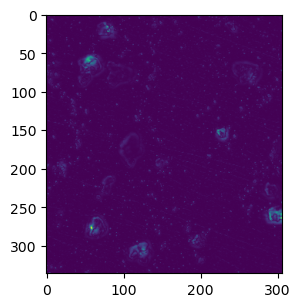

376.95953


In [ ]:
# comparison with bicubic and nearest neighbour interpolation

interp_sr = np.zeros_like(sr)
for i in range(sr.shape[2]):
    interp_sr[:,:,i] = cv2.resize(lr[:,:,i], (sr.shape[1], sr.shape[0]), interpolation = cv2.INTER_CUBIC )

# interp_err_l2 = np.mean((sr - interp_sr)**2,2)
interp_err_l1 = np.mean(np.abs(sr - interp_sr),2)

show_image(interp_err_l1)
print(np.sum(interp_err_l1))
# show_image(interp_err_l2)
# print(np.sum(interp_err_l2))


In [ ]:

interp_err_sam = np.zeros(sr.shape[:2])
height = sr.shape[0]
width = sr.shape[1]
for r in range(height):
    for c in range(width):
        # Extract spectral vector for pixel (r, c) from tensor_A
        # Shape will be [bands] after squeezing the batch and spatial dimensions
        spectral_vector_A = sr[r, c, :] # Remove batch dim and spatial dims of size 1

        # Extract spectral vector for pixel (r, c) from tensor_B
        spectral_vector_B = interp_sr[r, c,:]

        # Calculate dot product
        dot_product = np.dot(spectral_vector_A, spectral_vector_B)

        # Calculate magnitudes (L2 norms)
        norm_A = np.linalg.norm(spectral_vector_A)
        norm_B = np.linalg.norm(spectral_vector_B)

        # Avoid division by zero for black pixels (zero vectors)
        if norm_A == 0.0 or norm_B == 0.0:
            angle = 0.0 # Or NaN, depending on desired behavior for black pixels
        else:
            # Calculate cosine of the angle
            cosine_angle = dot_product / (norm_A * norm_B)
            # Clamp to prevent numerical issues (arccos domain is [-1, 1])
            cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
            # Calculate the angle in radians
            angle = np.acos(cosine_angle)

        interp_err_sam[r, c] = angle


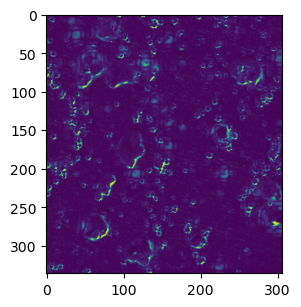

167.15207767070385


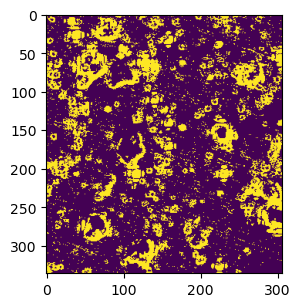

In [ ]:

show_image(interp_err_sam)
print(np.degrees(interp_err_sam.max()))
sam_thr = np.radians(10)
show_image(interp_err_sam>sam_thr)

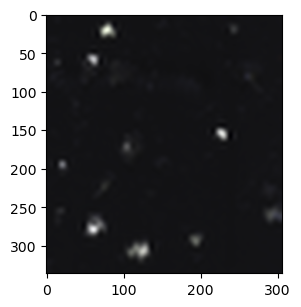

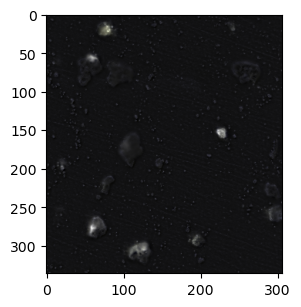

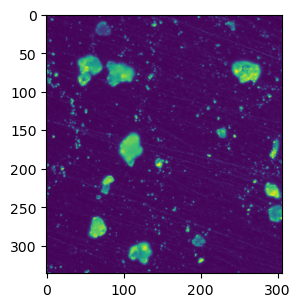

In [ ]:
interp_sr_rgb = hsi_to_rgb(interp_sr, wl_cal)
show_image(interp_sr_rgb)
show_image(sr_rgb)
show_image(pan)

# Evaluate the metrics according to Whispers challenge 2022

Evaluate the same indices for all other methods

In [6]:
# load the low res HS image:
matfile_LR = io.loadmat(r"Datasets/aviva_1mm_aligned_r3.mat")
LR = normalize_np(matfile_LR["I_MS_LR"])
PAN = matfile_LR["I_PAN"][:-8,:]
# PAN = matfile_LR["I_PAN"][:200,:]
ch = LR.shape[2]
WL = matfile_LR["Wavelengths"].squeeze()

# load the reference
matfile_ref = io.loadmat(r"Outputs/comparison/avivaface_sr03mm_vs_hr1mm.mat")
HR = normalize_np(matfile_ref["HR"])
H, W = HR.shape[:2]

# upscale the LR to HR dimensions
LRup = np.zeros((H,W,ch))
# interpolations = [ cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_CUBIC, cv2.INTER_LANCZOS4]
for i in range(ch):
    LRup[:,:,i] = cv2.resize(LR[:,:,i], (W,H), interpolation = cv2.INTER_CUBIC)


# now load the pansharpened images with different methods 
methods = ["RPNN","AWLP", "GS", "GSA", "MTF_GLP", "CUBIC", "REF"] # removed "MF_HG"
ratio = 3
sensor = "unspecified"
block_size = 16
alpha = 1
beta = 1


# with ref
ergas_list = []
sam_list = []
q2n_list = []
pnsr_list = []

# no ref
d_s_list = []
d_lambda_k_list = []
qstar_list = []

# Overall
oa_list = []



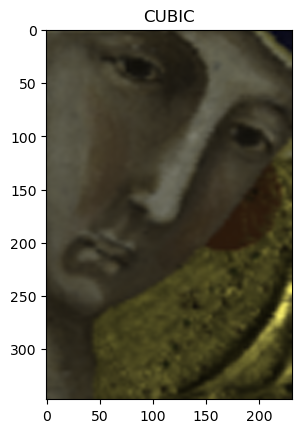

CUBIC
ERGAS:      6.8806
SAM:        2.1955
Q2n:        20.6750
D_lambda_K: -30.7778
D_s:        0.3115
Q*:         21.8806
OA:         21.2778


In [ ]:

for method in methods:
    folder = r"Outputs from standard methods"
    if method not in ("RPNN","REF", "CUBIC"): # no need to load from matlab files
        matpath = os.path.join(folder, method+"_results.mat")
        matfile = io.loadmat(matpath)
        # print(matfile.keys())
        matvar = "SR_"+method

    if method == "RPNN":
        #matfile = io.loadmat(r"Outputs/R-PNN/20250724_183019/aviva_1mm_aligned_r3_R-PNN.mat")
        #matfile = io.loadmat(r"Outputs/R-PNN/20250718_182728/aviva_1mm_aligned_r3_R-PNN.mat")
        matfile = io.loadmat(r"Outputs/R-PNN/20250725_113008/aviva_1mm_aligned_r3_R-PNN.mat")
        # matfile = io.loadmat(r"Outputs/R-PNN/20250725_130200/aviva_1mm_aligned_r3_R-PNN.mat")

        SR = normalize_np(matfile["I_MS"][:-8,:,:])
        #SR = normalize_np(matfile["I_MS"][:200,:,:])
        #SR = matfile[matvar]
    elif method == "CUBIC":
        SR = normalize_np(LRup)
    elif method == "REF":
        SR = HR
    else:
        SR = normalize_np(matfile[matvar][:-8,:,:]) # skip the bottom 8 rows of pixels

    #print the images
    plt.imshow(hsi_to_rgb(SR, WL))
    plt.title(method)
    plt.show()

    # with ref
    ergas = ERGAS(SR,HR, ratio)
    #ergas = "NA"
    ergas_list.append(ergas)
    sam = SAM(SR,HR)
    #sam = "NA"
    sam_list.append(sam)
    # q2n,_ = Q2n(SR, HR)
    q2n = Q2n(SR, HR)
    # q2n = "NA"
    q2n_list.append(q2n)

    # no ref
    d_s = D_S(SR, PAN)
    d_s_list.append(d_s)
    if method == "CUBIC":
        d_lambda_k = D_lambda_K(SR,LRup, ratio, sensor, block_size, degrade = False)
        d_lambda_k_list.append(d_lambda_k)
    else:
        d_lambda_k = D_lambda_K(SR,LRup, ratio, sensor, block_size)
        d_lambda_k_list.append(d_lambda_k)
    qstar = ((1-d_lambda_k)**alpha)*((1-d_s)**beta)
    qstar_list.append(qstar)

    # Overall
    oa = np.mean([qstar, q2n])
    # oa = "NA"
    oa_list.append(oa)

    # Print all metrics with names
    
    print(method)
    print(f"ERGAS:      {ergas:.4f}")
    print(f"SAM:        {sam:.4f}")
    print(f"Q2n:        {q2n:.4f}")
    print(f"D_lambda_K: {d_lambda_k:.4f}")
    print(f"D_s:        {d_s:.4f}")
    print(f"Q*:         {qstar:.4f}")
    print(f"OA:         {oa:.4f}")
    

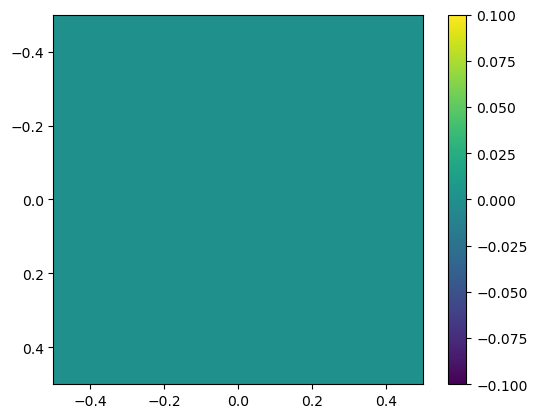

In [4]:
my_list = d_lambda_k_list
diff_matrix = np.zeros((len(my_list),len(my_list)) )
for i in range(len(my_list)):
    for j in range(len(my_list)):
        diff_matrix[i,j] = my_list[i] - my_list[j]

plt.imshow(diff_matrix)
plt.colorbar()
plt.show()




In [26]:
diff_matrix = np.zeros(len(my_list))
diff_matrix.shape

(7,)

In [7]:
methods = ["RPNN","AWLP", "GS", "GSA", "MTF_GLP", "CUBIC", "REF"] 
SR_list = []
for method in methods:
    folder = r"Outputs from standard methods"
    if method not in ("RPNN","REF", "CUBIC"): # no need to load from matlab files
        matpath = os.path.join(folder, method+"_results.mat")
        matfile = io.loadmat(matpath)
        # print(matfile.keys())
        matvar = "SR_"+method

    if method == "RPNN":
        #matfile = io.loadmat(r"Outputs/R-PNN/20250724_183019/aviva_1mm_aligned_r3_R-PNN.mat")
        #matfile = io.loadmat(r"Outputs/R-PNN/20250718_182728/aviva_1mm_aligned_r3_R-PNN.mat")
        matfile = io.loadmat(r"Outputs/R-PNN/20250725_113008/aviva_1mm_aligned_r3_R-PNN.mat")
        # matfile = io.loadmat(r"Outputs/R-PNN/20250725_130200/aviva_1mm_aligned_r3_R-PNN.mat")

        SR = normalize_np(matfile["I_MS"][:-8,:,:])
        #SR = normalize_np(matfile["I_MS"][:200,:,:])
        #SR = matfile[matvar]
        SR_list.append(SR)
    elif method == "CUBIC":
        SR = normalize_np(LRup)
        SR_list.append(SR)
    elif method == "REF":
        SR = HR
        SR_list.append(SR)
    else:
        SR = normalize_np(matfile[matvar][:-8,:,:]) # skip the bottom 8 rows of pixels
        SR_list.append(SR)

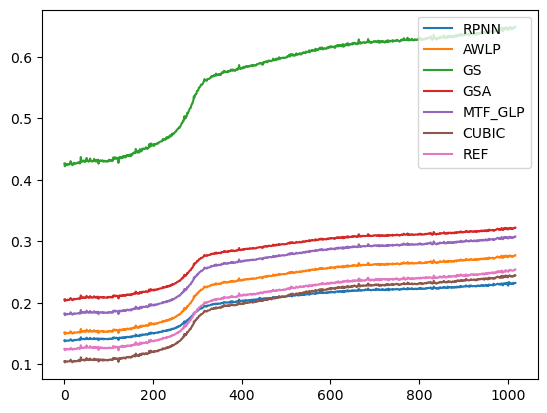

In [9]:
for i in range(len(methods)):
    sr = SR_list[i]
    plt.plot(sr[100,100,:], label = methods[i])
    
plt.legend()
plt.show()


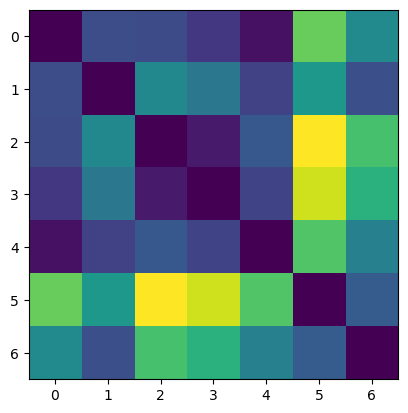

[[0.00000000e+00 1.56992293e+00 1.55373521e+00 1.08482224e+00
  2.99683291e-01 5.12393600e+00 3.19460662e+00]
 [1.56992293e+00 0.00000000e+00 3.11584164e+00 2.64513099e+00
  1.29175210e+00 3.55718928e+00 1.63160167e+00]
 [1.55373521e+00 3.11584164e+00 0.00000000e+00 4.75727637e-01
  1.82716989e+00 6.67055992e+00 4.74146756e+00]
 [1.08482224e+00 2.64513099e+00 4.75727637e-01 0.00000000e+00
  1.35620628e+00 6.20018788e+00 4.27108076e+00]
 [2.99683291e-01 1.29175210e+00 1.82716989e+00 1.35620628e+00
  0.00000000e+00 4.84758882e+00 2.91815927e+00]
 [5.12393600e+00 3.55718928e+00 6.67055992e+00 6.20018788e+00
  4.84758882e+00 0.00000000e+00 1.94957508e+00]
 [3.19460662e+00 1.63160167e+00 4.74146756e+00 4.27108076e+00
  2.91815927e+00 1.94957508e+00 8.53773646e-07]]


In [16]:
def SAM_vector(a, b):
    """
    Compute SAM (in degrees) between two 1D spectral vectors.
    """
    a = np.array(a).astype(np.float64)
    b = np.array(b).astype(np.float64)

    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    dot_product = np.dot(a, b)

    # Avoid division by zero
    if norm_a == 0 or norm_b == 0:
        return np.nan

    angle = np.arccos(np.clip(dot_product / (norm_a * norm_b), -1.0, 1.0))
    return np.degrees(angle)

sam = np.zeros((len(methods),len(methods)))
for i in range(len(methods)):
    for j in range(len(methods)):
        sam[i,j] = SAM_vector(SR_list[i][100, 100, :], SR_list[j][100, 100, :])

plt.imshow(sam)
plt.show()

print(sam)



# linearly fit the datasets to the original measurements

In [8]:
def estimate_global_linear_fit(X, Y):
    """
    Estimate the global linear fit parameters (amplitude a and intercept b) such that:
        Y ≈ a * X + b

    Parameters
    ----------
    X : np.ndarray
        Reference hyperspectral datacube of shape (H, W, B).
    Y : np.ndarray
        Target hyperspectral datacube of same shape (H, W, B).

    Returns
    -------
    a : float
        Estimated amplitude (slope).
    b : float
        Estimated intercept (bias).
    """
    if X.shape != Y.shape:
        raise ValueError("Input datacubes must have the same shape.")

    # Flatten the datacubes
    x = X.reshape(-1)
    y = Y.reshape(-1)

    # Solve least squares for y = a*x + b
    A = np.vstack([x, np.ones_like(x)]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]

    return a, b



In [10]:
# X and Y: datacubes of shape (231, 348, 1018)
X_fitted_list = []
for i in range(len(SR_list)-1):
    sr = SR_list[i]
    a, b = estimate_global_linear_fit(sr, SR_list[-1])
    X_fitted = a*sr +b
    print(f"Amplitude (a): {a:.6f}")
    print(f"Intercept (b): {b:.6f}")
    X_fitted_list.append(X_fitted)


Amplitude (a): 1.277651
Intercept (b): -0.048870
Amplitude (a): 0.921294
Intercept (b): -0.009965
Amplitude (a): 0.513935
Intercept (b): -0.075030
Amplitude (a): 0.977270
Intercept (b): -0.054082
Amplitude (a): 0.969285
Intercept (b): -0.049703
Amplitude (a): 0.829293
Intercept (b): 0.047058


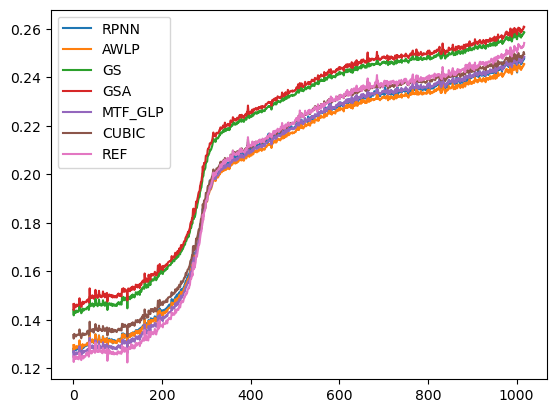

In [14]:
for i in range(len(methods)-1):
    sr = X_fitted_list[i]
    plt.plot(sr[100,100,:], label = methods[i])
plt.plot(SR_list[-1][100,100,:], label = "REF")
plt.legend()
plt.show()